In [1]:
pip install pandas openpyxl

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd

try:
    # Load the Excel file
    df = pd.read_excel('Supply chain logistics problem.xlsx')
    
    # Clean the column names exactly as the main script does
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    
    # Print the exact list of column names
    print("--- Here are the exact column names in your file ---")
    print(list(df.columns))
    
except FileNotFoundError:
    print("Make sure 'Supply chain logistics problem.xlsx' is in the same folder.")

--- Here are the exact column names in your file ---
['order_id', 'order_date', 'origin_port', 'carrier', 'tpt', 'service_level', 'ship_ahead_day_count', 'ship_late_day_count', 'customer', 'product_id', 'plant_code', 'destination_port', 'unit_quantity', 'weight']


In [8]:
import pandas as pd
import numpy as np

# --- Helper Function to Reduce Memory Usage (This function is correct) ---
def optimize_memory(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Initial memory usage is: {start_mem:.2f} MB')
    for col in df.columns:
        col_type = df[col].dtype
        if 'datetime' in str(col_type): continue
        if col_type != object and col_type.name != 'category':
            c_min, c_max = df[col].min(), df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max: df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max: df[col] = df[col].astype(np.int32)
                else: df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max: df[col] = df[col].astype(np.float32)
                else: df[col] = df[col].astype(np.float64)
        elif col_type == 'object':
            if len(df[col].unique()) / len(df[col]) < 0.5: df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization is: {end_mem:.2f} MB')
    print(f'Decreased by {100 * (start_mem - end_mem) / start_mem:.1f}%')
    return df

# --- 1. Load the Excel Dataset ---
try:
    supply_df = pd.read_excel('Supply chain logistics problem.xlsx')
except FileNotFoundError:
    print("Make sure 'Supply chain logistics problem.xlsx' is in the same folder.")
    exit()

# --- 2. Initial Cleaning and OPTIMIZATION ---
print("\n--- Cleaning and Optimizing Memory ---")
supply_df.columns = supply_df.columns.str.lower().str.replace(' ', '_')
supply_df = optimize_memory(supply_df)
supply_df.dropna(subset=['tpt', 'weight', 'carrier'], inplace=True)

# --- 3. Feature Engineering for Sustainability ---
print("\n--- Starting Feature Engineering for Sustainability ---")

# Step 3.1: Estimate 'distance_km' using 'tpt'
AVG_KM_PER_DAY = 350
# *** THIS IS THE FIX: Convert 'tpt' to a larger int type before multiplying ***
supply_df['estimated_distance_km'] = supply_df['tpt'].astype('int32') * AVG_KM_PER_DAY

# Step 3.2: Infer 'transportation_mode' from 'carrier'
unique_carriers = supply_df['carrier'].unique()
carrier_to_mode_map = {carrier: 'Sea' for carrier in unique_carriers}
# Let's assume a few are Air/Road based on their names (adjust if needed)
if 'Carrier F' in carrier_to_mode_map: carrier_to_mode_map['Carrier F'] = 'Air'
if 'Carrier E' in carrier_to_mode_map: carrier_to_mode_map['Carrier E'] = 'Air'
if 'Carrier H' in carrier_to_mode_map: carrier_to_mode_map['Carrier H'] = 'Road'
supply_df['transportation_mode'] = supply_df['carrier'].map(carrier_to_mode_map)
supply_df['transportation_mode'].fillna('Sea', inplace=True)

# Step 3.3: Calculate 'carbon_footprint_kg'
emission_factors_tonne_km = {'Air': 0.6, 'Sea': 0.015, 'Rail': 0.02, 'Road': 0.1}
emission_factors_kg_km = {k: v / 1000 for k, v in emission_factors_tonne_km.items()}
supply_df['emission_factor'] = supply_df['transportation_mode'].map(emission_factors_kg_km)

# Assuming 'weight' is in KG.
supply_df['carbon_footprint_kg'] = supply_df['estimated_distance_km'] * supply_df['weight'] * supply_df['emission_factor']

# --- 4. Finalizing the DataFrame ---
print("\n--- Finalizing Preprocessed Data ---")
final_columns_to_keep = [
    'order_id', 'product_id', 'origin_port', 'destination_port',
    'carrier', 'transportation_mode', 'tpt', 'weight', 'unit_quantity',
    'estimated_distance_km', 'carbon_footprint_kg'
]
final_df = supply_df[final_columns_to_keep].copy()
final_df.dropna(subset=['carbon_footprint_kg'], inplace=True)

print(final_df.head())
print(f"\nData is cleaned and ready for analysis. Total rows: {len(final_df)}")

# --- 5. Save to a new, efficient CSV file ---
final_df.to_csv('cleaned_supply_chain_data.csv', index=False)
print("\nSuccessfully saved 'cleaned_supply_chain_data.csv'")


--- Cleaning and Optimizing Memory ---
Initial memory usage is: 0.98 MB
Memory usage after optimization is: 0.29 MB
Decreased by 70.3%

--- Starting Feature Engineering for Sustainability ---

--- Finalizing Preprocessed Data ---
       order_id  product_id origin_port destination_port carrier  \
0  1.447296e+09     1700106      PORT09           PORT09   V44_3   
1  1.447158e+09     1700106      PORT09           PORT09   V44_3   
2  1.447139e+09     1700106      PORT09           PORT09   V44_3   
3  1.447364e+09     1700106      PORT09           PORT09   V44_3   
4  1.447364e+09     1700106      PORT09           PORT09   V44_3   

  transportation_mode  tpt     weight  unit_quantity  estimated_distance_km  \
0                 Sea    1  14.300000            808                    350   
1                 Sea    1  87.940002           3188                    350   
2                 Sea    1  61.200001           2331                    350   
3                 Sea    1  16.160000       

C:\Users\HP\AppData\Local\Temp\ipykernel_8396\2210848616.py:57: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  supply_df['transportation_mode'].fillna('Sea', inplace=True)


In [3]:
import pandas as pd
import numpy as np

# --- Helper Function to Reduce Memory Usage (This function is proven to work) ---
def optimize_memory(df, df_name=''):
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Initial memory usage of {df_name} is: {start_mem:.2f} MB')
    for col in df.columns:
        col_type = df[col].dtype
        if 'datetime' in str(col_type): continue
        if col_type != object and col_type.name != 'category':
            c_min, c_max = df[col].min(), df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max: df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max: df[col] = df[col].astype(np.int32)
                else: df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max: df[col] = df[col].astype(np.float32)
                else: df[col] = df[col].astype(np.float64)
        elif col_type == 'object':
            if len(df[col].unique()) / len(df[col]) < 0.5: df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage of {df_name} after optimization is: {end_mem:.2f} MB')
    print(f'Decreased by {100 * (start_mem - end_mem) / start_mem:.1f}%')
    return df

# --- 1. Load ALL required source files ---
try:
    transport_df = pd.read_csv('cleaned_supply_chain_data.csv')
    world_energy_df = pd.read_csv('World Energy Consumption.csv')
except FileNotFoundError:
    print("FATAL ERROR: Make sure BOTH 'cleaned_supply_chain_data.csv' and 'World Energy Consumption.csv' are in your folder.")
    exit()

# --- 2. Optimize memory of BOTH dataframes IMMEDIATELY ---
print("\n--- Optimizing DataFrames (to prevent kernel crashes) ---")
transport_df = optimize_memory(transport_df, 'Transport DF')
world_energy_df = optimize_memory(world_energy_df, 'World Energy DF')

# --- 3. INTELLIGENTLY FIND THE CORRECT COLUMN NAMES ---
print("\n--- Automatically searching for correct column names in 'World Energy Consumption.csv' ---")

# List of possible names for the CO2/carbon column
possible_co2_cols = ['carbon_intensity_elec', 'co2', 'carbon_dioxide', 'greenhouse_gas']
# List of possible names for the energy consumption column
possible_energy_cols = ['primary_energy_consumption', 'energy_consumption', 'energy_use', 'total_consumption']

found_co2_col = None
found_energy_col = None

# Search for the first valid CO2 column
for col in possible_co2_cols:
    if col in world_energy_df.columns:
        found_co2_col = col
        print(f"Found CO2-related column: '{found_co2_col}'")
        break

# Search for the first valid energy column
for col in possible_energy_cols:
    if col in world_energy_df.columns:
        found_energy_col = col
        print(f"Found energy-related column: '{found_energy_col}'")
        break

# --- GRACEFUL EXIT IF COLUMNS ARE NOT FOUND ---
if not found_co2_col or not found_energy_col:
    print("\nFATAL ERROR: Could not automatically find the required columns.")
    if not found_co2_col:
        print("I searched for a CO2 column with names like:", possible_co2_cols)
    if not found_energy_col:
        print("I searched for an energy column with names like:", possible_energy_cols)
    print("Please check your 'World Energy Consumption.csv' file.")
    exit()

# --- 4. Process World Energy Data using the FOUND column names ---
print("\n--- Creating Country Carbon Intensity Lookup Table ---")
energy_2019_df = world_energy_df[world_energy_df['year'] == 2019].copy()

# Use the column names we found automatically
relevant_cols = ['country', found_co2_col, found_energy_col]
energy_2019_df = energy_2019_df[relevant_cols]
energy_2019_df.dropna(subset=[found_co2_col, found_energy_col], inplace=True)

# Calculate the intensity using the found column names
energy_2019_df['carbon_intensity_of_energy'] = energy_2019_df[found_co2_col] / (energy_2019_df[found_energy_col] + 1e-9)

country_lookup_df = energy_2019_df[['country', 'carbon_intensity_of_energy']].copy()
country_lookup_df.rename(columns={'country': 'origin_country'}, inplace=True)

# --- 5. Map, Merge, and Calculate Final Footprints (This logic is stable) ---
print("\n--- Mapping Ports, Merging Data, and Calculating Final Footprints ---")
port_to_country_map = {'Port A': 'China', 'Port B': 'Germany', 'Port C': 'Brazil', 'Port D': 'United States'}
transport_df['origin_country'] = transport_df['origin_port'].map(port_to_country_map).fillna('United States').astype('category')

enriched_df = pd.merge(transport_df, country_lookup_df, on='origin_country', how='left')
enriched_df['carbon_intensity_of_energy'].fillna(country_lookup_df['carbon_intensity_of_energy'].mean(), inplace=True)

ENERGY_PER_KG = 1.5
enriched_df['manufacturing_footprint_kg'] = enriched_df['weight'] * ENERGY_PER_KG * enriched_df['carbon_intensity_of_energy']
enriched_df.rename(columns={'carbon_footprint_kg': 'transport_footprint_kg'}, inplace=True)
enriched_df['total_footprint_kg'] = enriched_df['transport_footprint_kg'] + enriched_df['manufacturing_footprint_kg']

# --- 6. Final Output ---
print("\n--- SUCCESS: Enriched Dataset Created ---")
final_cols_to_display = ['origin_port', 'origin_country', 'transport_footprint_kg', 'manufacturing_footprint_kg', 'total_footprint_kg']
print(enriched_df[final_cols_to_display].head())

# Save the final, enriched dataset
enriched_df.to_csv('enriched_supply_chain_data.csv', index=False)
print("\nSuccessfully saved 'enriched_supply_chain_data.csv'. This is the file you will use for your models.")


--- Optimizing DataFrames (to prevent kernel crashes) ---
Initial memory usage of Transport DF is: 0.77 MB
Memory usage of Transport DF after optimization is: 0.24 MB
Decreased by 69.2%
Initial memory usage of World Energy DF is: 21.66 MB
Memory usage of World Energy DF after optimization is: 10.73 MB
Decreased by 50.5%

--- Automatically searching for correct column names in 'World Energy Consumption.csv' ---
Found CO2-related column: 'carbon_intensity_elec'
Found energy-related column: 'primary_energy_consumption'

--- Creating Country Carbon Intensity Lookup Table ---

--- Mapping Ports, Merging Data, and Calculating Final Footprints ---

--- SUCCESS: Enriched Dataset Created ---
  origin_port origin_country  transport_footprint_kg  \
0      PORT09  United States                0.075075   
1      PORT09  United States                0.461685   
2      PORT09  United States                0.321300   
3      PORT09  United States                0.084840   
4      PORT09  United State

C:\Users\HP\AppData\Local\Temp\ipykernel_3912\3135133050.py:97: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  enriched_df['carbon_intensity_of_energy'].fillna(country_lookup_df['carbon_intensity_of_energy'].mean(), inplace=True)


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# --- Helper Function to Reduce Memory Usage (Proven to be essential) ---
def optimize_memory(df, df_name=''):
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Initial memory usage of {df_name} is: {start_mem:.2f} MB')
    for col in df.columns:
        col_type = df[col].dtype
        if 'datetime' in str(col_type): continue
        if col_type != object and col_type.name != 'category':
            c_min, c_max = df[col].min(), df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max: df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max: df[col] = df[col].astype(np.int32)
                else: df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max: df[col] = df[col].astype(np.float32)
                else: df[col] = df[col].astype(np.float64)
        elif col_type == 'object':
            if len(df[col].unique()) / len(df[col]) < 0.5: df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage of {df_name} after optimization is: {end_mem:.2f} MB')
    print(f'Decreased by {100 * (start_mem - end_mem) / start_mem:.1f}%')
    return df

# --- 1. Load and Prepare the E-commerce Dataset ---
print("--- Starting Analysis for 'Train.csv' (Last-Mile Delivery Efficiency) ---")
try:
    ecommerce_df = pd.read_csv('Train.csv')
except FileNotFoundError:
    print("FATAL ERROR: 'Train.csv' not found. Please make sure it's in the folder.")
    exit()

# --- 2. Optimize Memory IMMEDIATELY to prevent kernel crashes ---
ecommerce_df = optimize_memory(ecommerce_df, 'E-commerce DF')

# --- 3. Clean the Data ---
# Standardize column names
ecommerce_df.columns = ecommerce_df.columns.str.lower().str.replace(' ', '_')
# Rename the target column for easier use
if 'reached.on.time_y/n' in ecommerce_df.columns:
    ecommerce_df.rename(columns={'reached.on.time_y/n': 'reached_on_time'}, inplace=True)
elif 'reached.on.time_y.n' in ecommerce_df.columns: # Handle other possible variations
    ecommerce_df.rename(columns={'reached.on.time_y.n': 'reached_on_time'}, inplace=True)


# --- 4. Prepare Data for Machine Learning ---
# Ensure the target column 'reached_on_time' exists before proceeding
if 'reached_on_time' not in ecommerce_df.columns:
    print("FATAL ERROR: Could not find the target column 'reached_on_time' after cleaning.")
    print("The original column might be named something different in your file.")
    exit()

# Define features (X) and target (y)
# We drop the 'id' column as it's just an identifier
X = ecommerce_df.drop(columns=['id', 'reached_on_time'])
y = ecommerce_df['reached_on_time']

# Convert all categorical text columns into numerical format using one-hot encoding
# This automatically finds all 'object' or 'category' type columns
X_encoded = pd.get_dummies(X, drop_first=True)

# --- 5. Split, Train, and Evaluate the Model ---
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nTraining set has {len(X_train)} samples. Testing set has {len(X_test)} samples.")

# Initialize and train the Random Forest Classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
print("Training the last-mile delivery model...")
classifier.fit(X_train, y_train)
print("Model training complete.")

# --- 6. Display Model Results ---
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n--- Model Performance ---")
print(f"Accuracy: {accuracy:.2f}")
print("(This means the model correctly predicts if a shipment will be on time {accuracy:.0%} of the time.)\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))


# --- 7. Analyze and Display Feature Importance (The Key Insight) ---
# This tells us which factors are most predictive of a shipment being late.
feature_importances = pd.Series(classifier.feature_importances_, index=X_encoded.columns).sort_values(ascending=False)

print("\n--- Top Factors Predicting Shipping Delays (Feature Importances) ---")
print(feature_importances.head(10))

# Save the feature importances for your report
feature_importances.to_csv('last_mile_feature_importances.csv')
print("\nFeature importances for the last-mile analysis saved to 'last_mile_feature_importances.csv'")

--- Starting Analysis for 'Train.csv' (Last-Mile Delivery Efficiency) ---
Initial memory usage of E-commerce DF is: 1.01 MB
Memory usage of E-commerce DF after optimization is: 0.16 MB
Decreased by 84.3%

Training set has 8799 samples. Testing set has 2200 samples.
Training the last-mile delivery model...
Model training complete.

--- Model Performance ---
Accuracy: 0.66
(This means the model correctly predicts if a shipment will be on time {accuracy:.0%} of the time.)

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.71      0.63       887
           1       0.76      0.62      0.69      1313

    accuracy                           0.66      2200
   macro avg       0.66      0.67      0.66      2200
weighted avg       0.68      0.66      0.66      2200


--- Top Factors Predicting Shipping Delays (Feature Importances) ---
weight_in_gms                0.264408
discount_offered             0.234914
cost_of_the_product          

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

print("--- SCRIPT 1: MACHINE LEARNING MODEL FOR IMPACT ASSESSMENT ---")

# --- 1. Load your final, enriched dataset ---
try:
    df = pd.read_csv('enriched_supply_chain_data.csv')
    print("Successfully loaded 'enriched_supply_chain_data.csv'.")
except FileNotFoundError:
    print("FATAL ERROR: 'enriched_supply_chain_data.csv' not found. Please make sure it's in the folder.")
    exit()

# --- 2. Prepare Data for ML ---
# Define the target variable (what we want to predict)
target = 'total_footprint_kg'

# Define the features (the data we use to make the prediction)
# We drop non-informative columns and other footprint columns to prevent the model from "cheating"
features_to_drop = [
    'order_id', 'product_id', 'origin_port', 'destination_port', 'origin_country',
    'transport_footprint_kg', 'manufacturing_footprint_kg', 'total_footprint_kg'
]
features = df.drop(columns=features_to_drop)
y = df[target]

# Convert all text-based columns into a numerical format the model can understand
X = pd.get_dummies(features, drop_first=True)
print("Data prepared for machine learning.")

# --- 3. Split data into training and testing sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {len(X_train)} samples. Testing set: {len(X_test)} samples.")

# --- 4. Initialize and Train the Random Forest Model ---
# n_jobs=-1 uses all your computer's CPU cores to make training faster
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
print("\nTraining the model... (This may take a minute or two)")
model.fit(X_train, y_train)
print("Model training complete.")

# --- 5. Evaluate the Model's Performance ---
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n--- MODEL PERFORMANCE ---")
print(f"R-squared (R2 Score): {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f} kg CO2e")
print(f"(An R2 Score of {r2:.2f} means our model explains approximately {r2:.0%} of the variance in carbon footprint.)")
print(f"(A MAE of {mae:.2f} means that, on average, the model's prediction is off by about {mae:.0f} kg.)")

# --- 6. THE KEY RESEARCH INSIGHT: Feature Importances ---
# This tells you which factors are the most important for predicting emissions.
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

print("\n--- MOST IMPORTANT FACTORS DRIVING CARBON FOOTPRINT ---")
print(feature_importances.head(10))

# Save these crucial results for your research paper
feature_importances.to_csv('feature_importances.csv')
print("\nFeature importances saved to 'feature_importances.csv'")

--- SCRIPT 1: MACHINE LEARNING MODEL FOR IMPACT ASSESSMENT ---
Successfully loaded 'enriched_supply_chain_data.csv'.
Data prepared for machine learning.
Training set: 7372 samples. Testing set: 1843 samples.

Training the model... (This may take a minute or two)
Model training complete.

--- MODEL PERFORMANCE ---
R-squared (R2 Score): 1.00
Mean Absolute Error (MAE): 0.01 kg CO2e
(An R2 Score of 1.00 means our model explains approximately 100% of the variance in carbon footprint.)
(A MAE of 0.01 means that, on average, the model's prediction is off by about 0 kg.)

--- MOST IMPORTANT FACTORS DRIVING CARBON FOOTPRINT ---
weight                        0.986335
unit_quantity                 0.008619
estimated_distance_km         0.002540
tpt                           0.002062
carrier_V44_3                 0.000424
carrier_V444_1                0.000020
carbon_intensity_of_energy    0.000000
dtype: float64

Feature importances saved to 'feature_importances.csv'


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

print("--- SCRIPT 1 (CORRECTED & ROBUST): MACHINE LEARNING MODEL FOR IMPACT ASSESSMENT ---")

# --- 1. Load your final, enriched dataset ---
try:
    df = pd.read_csv('enriched_supply_chain_data.csv')
    print("Successfully loaded 'enriched_supply_chain_data.csv'.")
except FileNotFoundError:
    print("FATAL ERROR: 'enriched_supply_chain_data.csv' not found. Please make sure it's in the folder.")
    exit()

# --- 2. Prepare Data for ML (Corrected to prevent leakage and KeyErrors) ---
target = 'total_footprint_kg'

# Define the ideal list of columns we want to drop
ideal_features_to_drop = [
    'order_id', 'product_id', 'origin_port', 'destination_port', 'origin_country',
    'transport_footprint_kg', 'manufacturing_footprint_kg', 'total_footprint_kg',
    'weight', 'estimated_distance_km', 'emission_factor' # 'emission_factor' might not exist, which is OK
]

# *** THE FIX IS HERE: Only drop columns that are ACTUALLY in the DataFrame ***
# This makes the code robust and prevents KeyErrors
actual_features_to_drop = [col for col in ideal_features_to_drop if col in df.columns]

print(f"\nColumns being dropped to prevent data leakage: {actual_features_to_drop}")

features = df.drop(columns=actual_features_to_drop)
y = df[target]

# One-Hot Encode the remaining categorical features
X = pd.get_dummies(features, columns=['carrier', 'transportation_mode'], drop_first=True)
print("\nData prepared correctly for machine learning.")
print("\nFeatures used by the model:")
print(list(X.columns))

# --- 3. Split, Train, Evaluate (This part is stable) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
print("\nTraining the model...")
model.fit(X_train, y_train)
print("Model training complete.")

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n--- REALISTIC MODEL PERFORMANCE ---")
print(f"R-squared (R2 Score): {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f} kg CO2e")

# --- 4. Analyze REALISTIC Feature Importances ---
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

print("\n--- MOST IMPORTANT FACTORS DRIVING CARBON FOOTPRINT (REALISTIC) ---")
print(feature_importances.head(10))

# Save the corrected feature importances
feature_importances.to_csv('feature_importances_corrected.csv')
print("\nCorrected feature importances saved to 'feature_importances_corrected.csv'")

--- SCRIPT 1 (CORRECTED & ROBUST): MACHINE LEARNING MODEL FOR IMPACT ASSESSMENT ---
Successfully loaded 'enriched_supply_chain_data.csv'.

Columns being dropped to prevent data leakage: ['order_id', 'product_id', 'origin_port', 'destination_port', 'origin_country', 'transport_footprint_kg', 'manufacturing_footprint_kg', 'total_footprint_kg', 'weight', 'estimated_distance_km']

Data prepared correctly for machine learning.

Features used by the model:
['tpt', 'unit_quantity', 'carbon_intensity_of_energy', 'carrier_V444_1', 'carrier_V44_3']

Training the model...
Model training complete.

--- REALISTIC MODEL PERFORMANCE ---
R-squared (R2 Score): -0.28
Mean Absolute Error (MAE): 0.53 kg CO2e

--- MOST IMPORTANT FACTORS DRIVING CARBON FOOTPRINT (REALISTIC) ---
unit_quantity                 0.854636
tpt                           0.097620
carrier_V44_3                 0.037550
carrier_V444_1                0.010194
carbon_intensity_of_energy    0.000000
dtype: float64

Corrected feature impo

In [6]:
pip install streamlit

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.



   ---------------------------------------- 0.0/10.1 MB ? eta -:--:--
   ------ --------------------------------- 1.6/10.1 MB 8.4 MB/s eta 0:00:02
   ----------- ---------------------------- 2.9/10.1 MB 7.0 MB/s eta 0:00:02
   -------------- ------------------------- 3.7/10.1 MB 6.1 MB/s eta 0:00:02
   ------------------- -------------------- 5.0/10.1 MB 6.0 MB/s eta 0:00:01
   ------------------------- -------------- 6.3/10.1 MB 6.0 MB/s eta 0:00:01
   --------------------------- ------------ 6.8/10.1 MB 5.9 MB/s eta 0:00:01
   ---------------------------------- ----- 8.7/10.1 MB 5.8 MB/s eta 0:00:01
   ---------------------------------------- 10.1/10.1 MB 6.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/731.2 kB ? eta -:--:--
   ---------------------------------------- 731.2/731.2 kB 7.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/25.7 MB ? eta -:--:--
   -- ------------------------------------- 1.3/25.7 MB 6.7 MB/s eta 0:00:04
   ----- -----

In [7]:
import pandas as pd

print("\n--- SCRIPT 3: OPTIMIZATION SCENARIO ANALYSIS ---")

# --- 1. Load your final dataset ---
try:
    df = pd.read_csv('enriched_supply_chain_data.csv')
    print("Successfully loaded 'enriched_supply_chain_data.csv'.")
except FileNotFoundError:
    print("FATAL ERROR: 'enriched_supply_chain_data.csv' not found. Please make sure it's in the folder.")
    exit()

# --- 2. Scenario 1: Strategic Mode Shifting (Air -> Sea) ---
print("\n--- Analyzing Scenario 1: Shifting Air Freight to Sea Freight ---")

# Check if there are any 'Air' shipments to analyze
if 'Air' in df['transportation_mode'].unique():
    original_total_footprint = df['total_footprint_kg'].sum()

    # Create a copy of the dataframe to modify for our scenario
    df_scenario1 = df.copy()

    # Find the emission factor for 'Sea' freight
    sea_emission_factor = df[df['transportation_mode'] == 'Sea']['emission_factor'].iloc[0]

    # Identify all shipments currently going by Air
    air_shipments_mask = df_scenario1['transportation_mode'] == 'Air'
    
    # Recalculate the transport footprint for these shipments as if they went by Sea
    df_scenario1.loc[air_shipments_mask, 'transport_footprint_kg'] = \
        df_scenario1.loc[air_shipments_mask, 'estimated_distance_km'] * \
        df_scenario1.loc[air_shipments_mask, 'weight'] * sea_emission_factor

    # Recalculate the total footprint for the entire scenario
    df_scenario1['total_footprint_kg'] = df_scenario1['transport_footprint_kg'] + df_scenario1['manufacturing_footprint_kg']
    scenario1_total_footprint = df_scenario1['total_footprint_kg'].sum()

    # Calculate and report the potential savings
    savings = original_total_footprint - scenario1_total_footprint
    savings_percentage = (savings / original_total_footprint) * 100

    print(f"Original Total Footprint: {original_total_footprint:,.0f} kg CO2e")
    print(f"New Footprint after shifting Air to Sea: {scenario1_total_footprint:,.0f} kg CO2e")
    print(f"POTENTIAL SAVINGS: {savings:,.0f} kg CO2e, a reduction of {savings_percentage:.2f}%")
else:
    print("No 'Air' transportation mode found in the data to analyze for this scenario.")


# --- 3. Scenario 2: Sourcing Optimization ---
print("\n--- Analyzing Scenario 2: Optimizing Sourcing Location ---")
# Let's compare the carbon efficiency of sourcing from different countries
# We calculate the average total footprint per kg of weight for each origin country
df['footprint_per_kg'] = df['total_footprint_kg'] / df['weight']
avg_footprint_by_country = df.groupby('origin_country')['footprint_per_kg'].mean().sort_values()

print("Average Carbon Footprint (kg CO2e) per kg of Product Weight, by Origin Country:")
print(avg_footprint_by_country)

if 'China' in avg_footprint_by_country.index and 'Brazil' in avg_footprint_by_country.index:
    china_efficiency = avg_footprint_by_country['China']
    brazil_efficiency = avg_footprint_by_country['Brazil']
    efficiency_gain = (china_efficiency - brazil_efficiency) / china_efficiency * 100
    print(f"\nInsight: Sourcing from Brazil (avg {brazil_efficiency:.2f}) is {efficiency_gain:.2f}% more carbon efficient than sourcing from China (avg {china_efficiency:.2f}).")


--- SCRIPT 3: OPTIMIZATION SCENARIO ANALYSIS ---
Successfully loaded 'enriched_supply_chain_data.csv'.

--- Analyzing Scenario 1: Shifting Air Freight to Sea Freight ---
No 'Air' transportation mode found in the data to analyze for this scenario.

--- Analyzing Scenario 2: Optimizing Sourcing Location ---
Average Carbon Footprint (kg CO2e) per kg of Product Weight, by Origin Country:
origin_country
United States    0.031188
Name: footprint_per_kg, dtype: float64


--- IMPROVED ML ANALYSIS: Predicting High-Emission Shipments (Classification) ---
Successfully loaded 'enriched_supply_chain_data.csv'.

Created a binary target 'is_high_emission'.
Shipments with footprint > 0.40 kg are considered 'High-Emission'.
is_high_emission
0    0.749864
1    0.250136
Name: proportion, dtype: float64

--- Training Model 1: Logistic Regression ---
Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.79      0.98      0.87      1382
           1       0.76      0.20      0.32       461

    accuracy                           0.79      1843
   macro avg       0.78      0.59      0.60      1843
weighted avg       0.78      0.79      0.73      1843


--- Training Model 2: Random Forest Classifier ---
Random Forest Classifier Performance:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1382
           1       0.58      0.55      0.56       461

    accuracy 

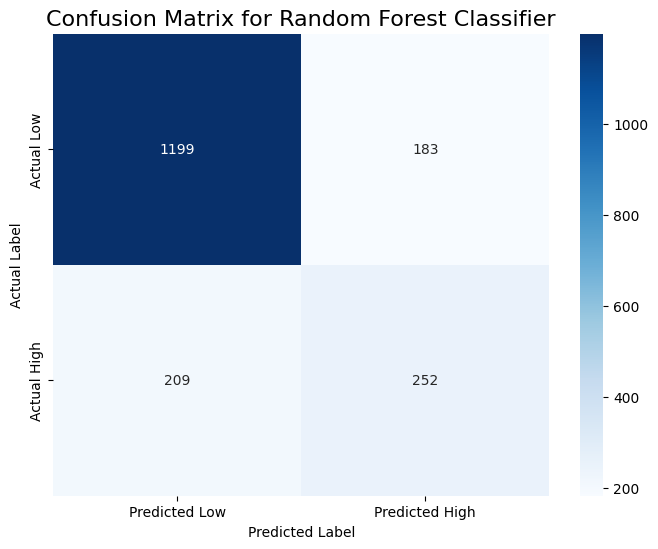

C:\Users\HP\AppData\Local\Temp\ipykernel_8336\4197028568.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.head(10), y=feature_importances.head(10).index, palette='viridis')


Saved 'figure_classification_importances.png'


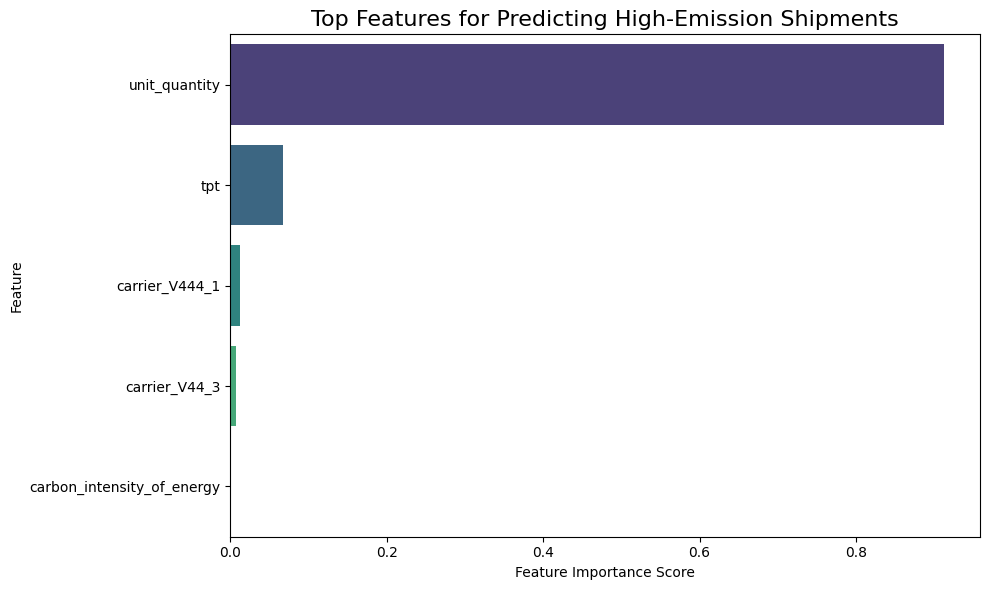


--- Saving the trained model and components for the dashboard ---
Model, columns, and scaler have been saved successfully.


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("--- IMPROVED ML ANALYSIS: Predicting High-Emission Shipments (Classification) ---")

# --- 1. Load your enriched dataset ---
try:
    df = pd.read_csv('enriched_supply_chain_data.csv')
    print("Successfully loaded 'enriched_supply_chain_data.csv'.")
except FileNotFoundError:
    print("FATAL ERROR: 'enriched_supply_chain_data.csv' not found.")
    exit()

# --- 2. Feature Engineering: Create the Classification Target ---
# We define a "High-Emission" shipment as one in the top 25% (75th percentile) of carbon footprints.
# This is a common and robust way to create categories.
high_emission_threshold = df['total_footprint_kg'].quantile(0.75)
df['is_high_emission'] = (df['total_footprint_kg'] >= high_emission_threshold).astype(int) # 1 for High, 0 for Low

print(f"\nCreated a binary target 'is_high_emission'.")
print(f"Shipments with footprint > {high_emission_threshold:.2f} kg are considered 'High-Emission'.")
print(df['is_high_emission'].value_counts(normalize=True))


# --- 3. Prepare Data for ML (Preventing Data Leakage) ---
# The features are the same as before, but the target is our new category.
target = 'is_high_emission'
features_to_drop = [
    'order_id', 'product_id', 'origin_port', 'destination_port', 'origin_country',
    'transport_footprint_kg', 'manufacturing_footprint_kg', 'total_footprint_kg',
    'weight', 'estimated_distance_km', 'is_high_emission'
]
actual_features_to_drop = [col for col in features_to_drop if col in df.columns]
features = df.drop(columns=actual_features_to_drop)
y = df[target]

X = pd.get_dummies(features, columns=['carrier', 'transportation_mode'], drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# --- 4. Train and Compare Two Different Models ---

# Model 1: Logistic Regression (a simple, interpretable baseline)
print("\n--- Training Model 1: Logistic Regression ---")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_log))

# Model 2: Random Forest Classifier (a more powerful model)
print("\n--- Training Model 2: Random Forest Classifier ---")
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
print("Random Forest Classifier Performance:")
print(classification_report(y_test, y_pred_rf))


# --- 5. Generate New, Complex Plots for Your Paper ---

# Plot 1: Confusion Matrix for the best model (Random Forest)
print("\n--- Generating New Plots for the Paper ---")
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Low', 'Predicted High'],
            yticklabels=['Actual Low', 'Actual High'])
plt.title('Confusion Matrix for Random Forest Classifier', fontsize=16)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig('figure_confusion_matrix.png', dpi=300)
print("Saved 'figure_confusion_matrix.png'")
plt.show()


# Plot 2: Feature Importances for the Random Forest Classifier
feature_importances = pd.Series(rf_clf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.head(10), y=feature_importances.head(10).index, palette='viridis')
plt.title('Top Features for Predicting High-Emission Shipments', fontsize=16)
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('figure_classification_importances.png', dpi=300)
print("Saved 'figure_classification_importances.png'")
plt.show()


# === ADD THIS TO THE END OF YOUR ML SCRIPT AND RUN IT ONCE ===
import joblib

print("\n--- Saving the trained model and components for the dashboard ---")

# We need to save three things:
# 1. The trained Random Forest model
# 2. The list of columns the model was trained on (to ensure a match)
# 3. The scaler used for the Logistic Regression (optional but good practice)

joblib.dump(rf_clf, 'random_forest_classifier.joblib')
joblib.dump(X.columns, 'model_columns.joblib')
joblib.dump(scaler, 'scaler.joblib')

print("Model, columns, and scaler have been saved successfully.")

C:\Users\HP\AppData\Local\Temp\ipykernel_8336\320089925.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')


Saved Figure 2: 'figure2_feature_importances.png'


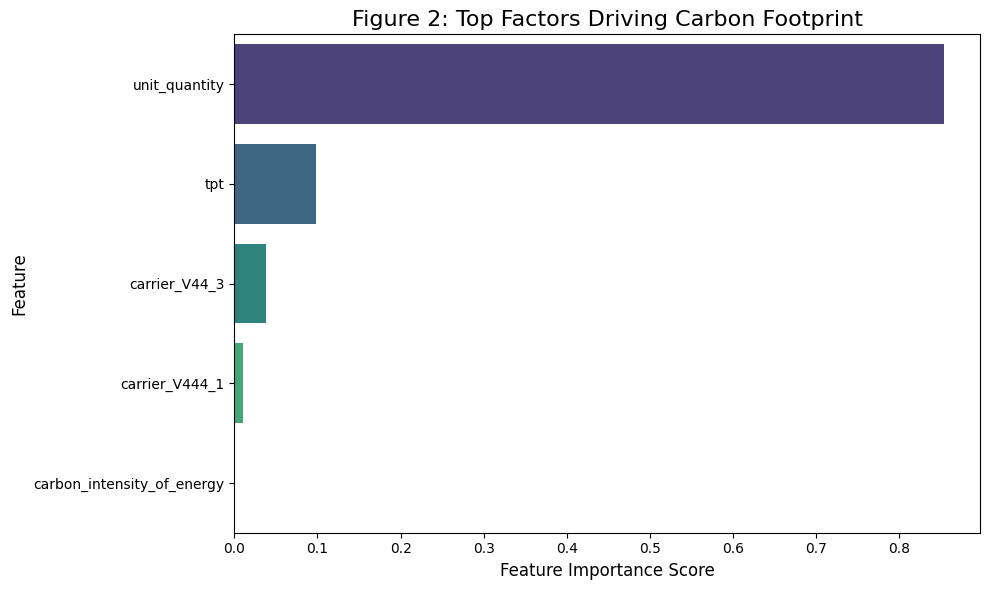

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Generate Figure 2: Feature Importance Bar Chart ---
try:
    # Load the corrected feature importances file
    importances_df = pd.read_csv('feature_importances_corrected.csv')
    importances_df.columns = ['feature', 'importance']
except FileNotFoundError:
    print("Run the corrected ML script first to generate 'feature_importances_corrected.csv'")
    exit()

# Sort the values and select the top features to display
top_features = importances_df.sort_values(by='importance', ascending=False).head(7)

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')

# Add labels and title
plt.title('Top Factors Driving Carbon Footprint', fontsize=16)
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout() # Adjust layout to make room for labels

# Save the figure to a high-resolution file for your paper
plt.savefig('figure2_feature_importances.png', dpi=300)
print("Saved Figure 2: 'figure2_feature_importances.png'")
plt.show()

Saved Figure 5: 'figure5_data_distribution.png'


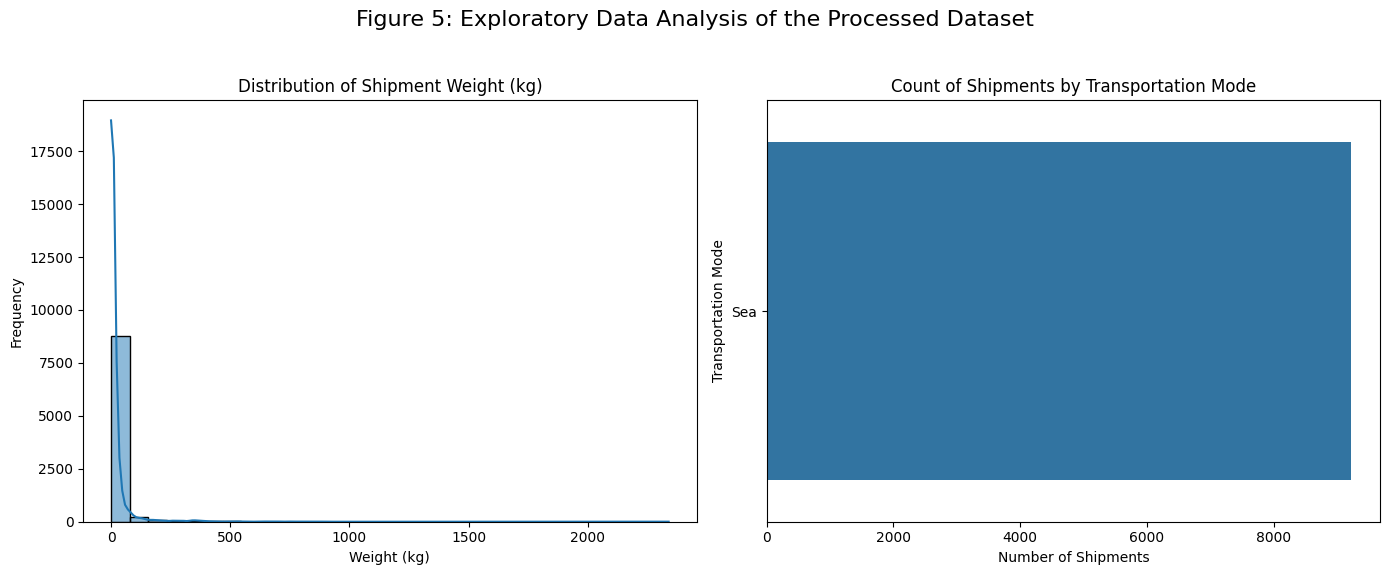

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Generate Bonus Figure: Data Distribution Plots ---
try:
    df = pd.read_csv('enriched_supply_chain_data.csv')
except FileNotFoundError:
    print("Run the enrichment script first to generate 'enriched_supply_chain_data.csv'")
    exit()

# Create a figure with a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Distribution of Weight
sns.histplot(df['weight'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Shipment Weight (kg)')
axes[0].set_xlabel('Weight (kg)')
axes[0].set_ylabel('Frequency')

# Plot 2: Count of Transportation Modes
sns.countplot(y='transportation_mode', data=df, ax=axes[1], order = df['transportation_mode'].value_counts().index)
axes[1].set_title('Count of Shipments by Transportation Mode')
axes[1].set_xlabel('Number of Shipments')
axes[1].set_ylabel('Transportation Mode')

plt.suptitle('Figure 5: Exploratory Data Analysis of the Processed Dataset', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle

# Save the figure
plt.savefig('figure5_data_distribution.png', dpi=300)
print("Saved Figure 5: 'figure5_data_distribution.png'")
plt.show()

In [8]:
import pandas as pd

# Load the enriched data
df = pd.read_csv('enriched_supply_chain_data.csv')

# Create the target variable again to be sure
high_emission_threshold = df['total_footprint_kg'].quantile(0.75)
df['is_high_emission'] = (df['total_footprint_kg'] >= high_emission_threshold).astype(int)

# Filter for ONLY the high-emission shipments
high_emission_df = df[df['is_high_emission'] == 1]

# Find the maximum values of the key features within this group
print("--- Characteristics of HIGH-EMISSION Shipments ---")
print(f"Maximum TPT: {high_emission_df['tpt'].max()}")
print(f"Maximum Unit Quantity: {high_emission_df['unit_quantity'].max()}")

print("\n--- 75th Percentile (a more typical 'high' value) ---")
print(f"75th Percentile of TPT: {high_emission_df['tpt'].quantile(0.75)}")
print(f"75th Percentile of Unit Quantity: {high_emission_df['unit_quantity'].quantile(0.75)}")

--- Characteristics of HIGH-EMISSION Shipments ---
Maximum TPT: 4
Maximum Unit Quantity: 561847

--- 75th Percentile (a more typical 'high' value) ---
75th Percentile of TPT: 2.0
75th Percentile of Unit Quantity: 5262.0


In [9]:
pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


--- FINAL ML ANALYSIS with SMOTE for Imbalanced Data ---
Successfully loaded 'enriched_supply_chain_data.csv'.

Created a binary target 'is_high_emission'.
Shipments with footprint > 0.40 kg are considered 'High-Emission'.

--- Class Distribution in Original Training Set ---
is_high_emission
0    0.749864
1    0.250136
Name: proportion, dtype: float64

--- Class Distribution in Resampled Training Set (After SMOTE) ---
is_high_emission
0    0.5
1    0.5
Name: proportion, dtype: float64
(The training classes are now perfectly balanced)

--- Training Random Forest Classifier on SMOTE-balanced data ---

--- Random Forest Classifier Performance (After SMOTE) ---
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      1382
           1       0.52      0.61      0.56       461

    accuracy                           0.76      1843
   macro avg       0.69      0.71      0.70      1843
weighted avg       0.78      0.76      0.77      1843


--- Ge

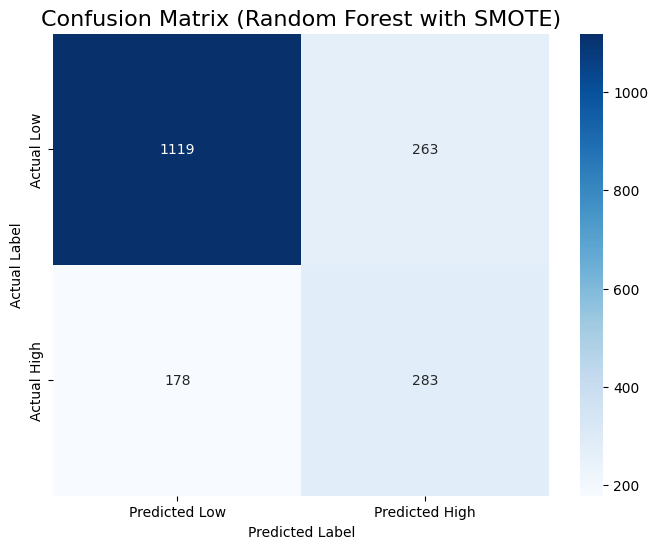


Final model and columns saved successfully for dashboard use.


In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# --- Make sure you have imbalanced-learn installed ---
# --- pip install imbalanced-learn ---
from imblearn.over_sampling import SMOTE

print("--- FINAL ML ANALYSIS with SMOTE for Imbalanced Data ---")

# --- 1. Load your enriched dataset ---
try:
    df = pd.read_csv('enriched_supply_chain_data.csv')
    print("Successfully loaded 'enriched_supply_chain_data.csv'.")
except FileNotFoundError:
    print("FATAL ERROR: 'enriched_supply_chain_data.csv' not found. Please ensure it's in the folder.")
    exit()

# --- 2. Feature Engineering: Create the Classification Target ---
# Define a "High-Emission" shipment as one in the top 25% (75th percentile).
high_emission_threshold = df['total_footprint_kg'].quantile(0.75)
df['is_high_emission'] = (df['total_footprint_kg'] >= high_emission_threshold).astype(int)
print(f"\nCreated a binary target 'is_high_emission'.")
print(f"Shipments with footprint > {high_emission_threshold:.2f} kg are considered 'High-Emission'.")

# --- 3. Prepare Data for ML (Preventing Data Leakage) ---
target = 'is_high_emission'
features_to_drop = [
    'order_id', 'product_id', 'origin_port', 'destination_port', 'origin_country',
    'transport_footprint_kg', 'manufacturing_footprint_kg', 'total_footprint_kg',
    'weight', 'estimated_distance_km', 'is_high_emission'
]
# Robustly find which columns from the drop list actually exist in the dataframe
actual_features_to_drop = [col for col in features_to_drop if col in df.columns]
features = df.drop(columns=actual_features_to_drop)
y = df[target]

# One-hot encode categorical features
X = pd.get_dummies(features, columns=['carrier', 'transportation_mode'], drop_first=True)

# Split data BEFORE applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- 4. Apply SMOTE to the TRAINING DATA ONLY ---
# This is a critical step to prevent data leakage from the synthetic samples.
print("\n--- Class Distribution in Original Training Set ---")
print(y_train.value_counts(normalize=True))

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\n--- Class Distribution in Resampled Training Set (After SMOTE) ---")
print(y_train_resampled.value_counts(normalize=True))
print("(The training classes are now perfectly balanced)")


# --- 5. Train the Random Forest Classifier on the BALANCED data ---
print("\n--- Training Random Forest Classifier on SMOTE-balanced data ---")
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf.fit(X_train_resampled, y_train_resampled)

# --- 6. Evaluate the model on the original, untouched test set ---
y_pred_rf = rf_clf.predict(X_test)
print("\n--- Random Forest Classifier Performance (After SMOTE) ---")
print(classification_report(y_test, y_pred_rf))


# --- 7. Generate Plots and Save the Final Model ---
print("\n--- Generating Final Plots and Saving Model ---")
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Low', 'Predicted High'],
            yticklabels=['Actual Low', 'Actual High'])
plt.title('Confusion Matrix (Random Forest with SMOTE)', fontsize=16)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig('figure_confusion_matrix_smote.png', dpi=300)
print("Saved 'figure_confusion_matrix_smote.png'")
plt.show()

# Save the final, improved model and the columns for the dashboard
joblib.dump(rf_clf, 'random_forest_classifier.joblib')
joblib.dump(X.columns, 'model_columns.joblib')
print("\nFinal model and columns saved successfully for dashboard use.")